In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import sys
# sys.path.append("/glade/u/home/dtmccoy/scripts")
import seaborn as sns
from numpy.ma import *
import datetime
from numpy import *
import glob
import matplotlib.pyplot as plt
import scipy.stats as st
import netCDF4 as nc
from global_land_mask import globe
from scipy import stats
%matplotlib inline 

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.clf()
plt.rcParams['figure.figsize'] = (15.0/2.5, 15.0/2.5)

<Figure size 600x400 with 0 Axes>

In [2]:
from con_models import get_cons
con, use_colors, varname, pvarname, modname, warming_modname, hiresmd = get_cons()

In [3]:
fpath      = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/parameter_250_w_control.nc'
data       = xr.open_dataset(fpath)

In [8]:
data

<xarray.Dataset>
Dimensions:                    (nmb_sim: 251)
Dimensions without coordinates: nmb_sim
Data variables: (12/46)
    micro_mg_dcs               (nmb_sim) float64 ...
    micro_mg_autocon_nd_exp    (nmb_sim) float64 ...
    Sample_nmb                 (nmb_sim) object ...
    cldfrc_dp1                 (nmb_sim) float64 ...
    cldfrc_dp2                 (nmb_sim) float64 ...
    clubb_C2rt                 (nmb_sim) float64 ...
    ...                         ...
    zmconv_ke                  (nmb_sim) float64 ...
    zmconv_ke_lnd              (nmb_sim) float64 ...
    zmconv_momcd               (nmb_sim) float64 ...
    zmconv_momcu               (nmb_sim) float64 ...
    zmconv_num_cin             (nmb_sim) int64 ...
    zmconv_tiedke_add          (nmb_sim) float64 ...
Attributes:
    history:  Tue Mar 15 13:16:45 2022: ncap2 -s micro_mg_dcs(0)=0.0005 param...
    NCO:      netCDF Operators version 4.9.5 (Homepage = http://nco.sf.net, C...

In [4]:
param_name=list(data.keys())

In [5]:
param_name

['micro_mg_dcs',
 'micro_mg_autocon_nd_exp',
 'Sample_nmb',
 'cldfrc_dp1',
 'cldfrc_dp2',
 'clubb_C2rt',
 'clubb_C6rt',
 'clubb_C6rtb',
 'clubb_C6thl',
 'clubb_C6thlb',
 'clubb_C8',
 'clubb_beta',
 'clubb_c1',
 'clubb_c11',
 'clubb_c14',
 'clubb_c_K10',
 'clubb_gamma_coef',
 'clubb_wpxp_L_thresh',
 'dust_emis_fact',
 'micro_mg_accre_enhan_fact',
 'micro_mg_autocon_fact',
 'micro_mg_autocon_lwp_exp',
 'micro_mg_berg_eff_factor',
 'micro_mg_effi_factor',
 'micro_mg_homog_size',
 'micro_mg_iaccr_factor',
 'micro_mg_max_nicons',
 'micro_mg_vtrmi_factor',
 'microp_aero_npccn_scale',
 'microp_aero_wsub_min',
 'microp_aero_wsub_scale',
 'microp_aero_wsubi_min',
 'microp_aero_wsubi_scale',
 'seasalt_emis_scale',
 'sol_factb_interstitial',
 'sol_factic_interstitial',
 'zmconv_c0_lnd',
 'zmconv_c0_ocn',
 'zmconv_capelmt',
 'zmconv_dmpdz',
 'zmconv_ke',
 'zmconv_ke_lnd',
 'zmconv_momcd',
 'zmconv_momcu',
 'zmconv_num_cin',
 'zmconv_tiedke_add']

In [6]:
f      = nc.Dataset(fpath)

In [21]:
enn = (np.arange(0,251)).tolist()
enn.remove(175)

In [22]:
len(enn)

250

In [23]:
u = 0
v = 250
print(len(enn),v)

250 250


In [24]:
M_plot = []
W_plot = []
b_coun  = []

In [25]:

#latitude range
latr1 = 30
latr2 = 80

In [26]:
#####Constants
Cp = 1004           #J/kg/K
Rd = 287            #J/kg/K
con= Rd/Cp

In [27]:
#binning
n_bins  = 1
M_range = (-7,2.5)

In [28]:
for en in enn[u:v]:
    # print(en)
    for i in ['U10', 'PSL', 'TREFHT', 'T850']:
        d_path = '/glade/campaign/cgd/projects/ppe/cam_ppe/rerun_PPE_250/PD/PD_timeseries/PPE_250_ensemble_PD.'+f'{en:03d}'+'/atm/hist/cc_PPE_250_ensemble_PD.'+f'{en:03d}'+'.h1.'+str(i)+'.nc'
        data =xr.open_dataset(d_path)
        
        lon  = data.variables['lon'][:]  #(lon: 288) [0.0, 1.25, 2.5, ... 356.25, 357.5, 358.75]
        lat  = data.variables['lat'][:]  #(lat: 192) [-90.0 , -89.057592, -88.115183, ... 88.115183,  89.057592, 90.0]
        time = data.variables['time'][:] #(time: 36)
#             
        locals()[str(en)+'_'+i] = data.variables[i][:]
    
        x_lat = np.array(lat)
        lat_ind1 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr1)).argmin()])[0]
        lat_ind2 = np.where(x_lat == x_lat.flat[np.abs(x_lat - (latr2)).argmin()])[0]
        lats = lat[lat_ind1[0]:lat_ind2[0]]

        x_lon = lon
        lon = np.array(lon)
        lon[lon > 180] = lon[lon > 180]-360

        maskm = np.ones((len(time),len(lats),len(lon)))

        for a in range(len(lats)):
            for b in range(len(lon)):
                if globe.is_land(lats[a], lon[b])==True:
                    maskm[:,a,b] = math.nan
        
        tmp  = locals()[str(en)+'_'+i]
        tmp2 = tmp[:,lat_ind1[0]:lat_ind2[0],:]
        MID  = np.multiply(maskm,tmp2)
        lats = np.array(lats)
        lon  = np.array(lon)
        locals()['MID'+i+'_'+str(en)]  = np.array(MID)
        
    theta_850_en = np.multiply(locals()['MIDT850_'+str(en)],(100000/85000)**con)
    theta_T2M_en = np.multiply(locals()['MIDTREFHT_'+str(en)],(100000/locals()['MIDPSL_'+str(en)])**con)
    
    M_en   = np.array(np.subtract(theta_T2M_en,theta_850_en)).reshape(-1)
    U10_en = np.array(locals()['MIDU10_'+str(en)]).reshape(-1)
    
    indx = np.isnan(M_en*U10_en)==False

    bin_means, bin_edges, binnumber       = stats.binned_statistic(M_en[indx], U10_en[indx], 'mean', bins=n_bins,range=M_range)

    W_plot.append(np.ma.masked_invalid(bin_means))
    

KeyboardInterrupt: 

In [ ]:
try_w_plot = np.array(W_plot)

In [ ]:
Wind = try_w_plot[:,0]

In [ ]:
correlation = []
param = []

In [17]:
for i in range(len(param_name)):
    if param_name[i]!='Sample_nmb':
        y = f.variables[param_name[i]][0:len(W_plot)]
        cor = st.spearmanr(Wind,y)
        cor = np.array(cor)
        correlation.append(cor[0])
        param.append(param_name[i])
    


<Figure size 2500x1500 with 0 Axes>

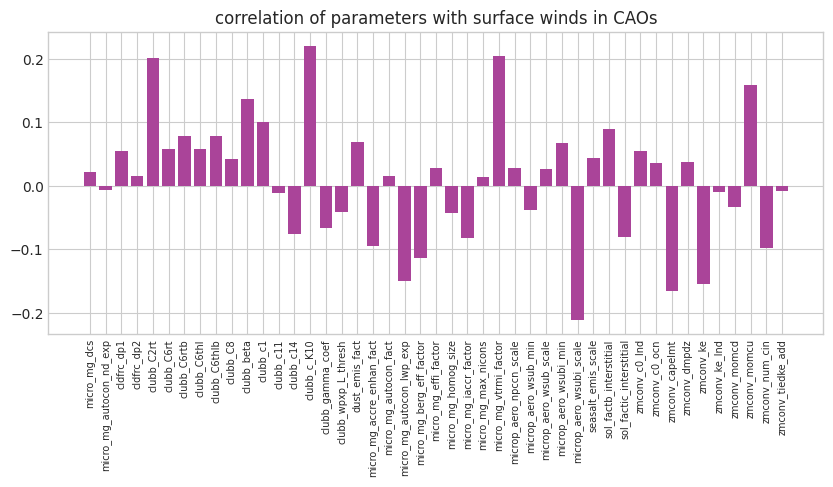

In [77]:
mpl.rcParams['figure.dpi'] = 100
plt.clf()
# plt.rcParams['figure.figsize'] = (25.0, 15.0)
fig = plt.figure(figsize=(10,4))
plt.style.use('seaborn-whitegrid')
plt.bar(arange(len(correlation)),correlation,tick_label=param,color=use_colors[4])
plt.xticks(rotation = 90,fontsize=7)
plt.title('correlation of parameters with surface winds in CAOs')
plt.savefig('../figures/parameter_correlation.png')

In [62]:
ind = np.argsort(W_plot)
x = np.sort(W_plot)

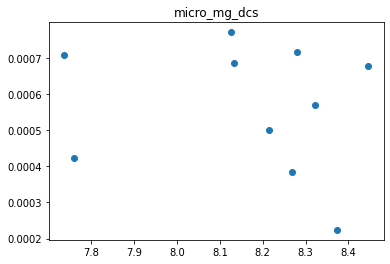

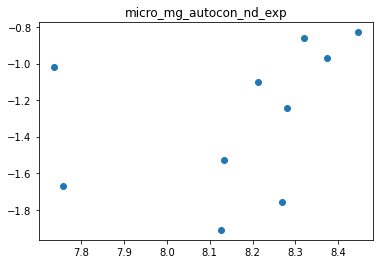

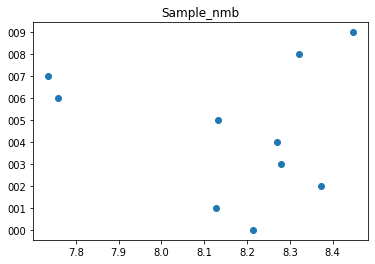

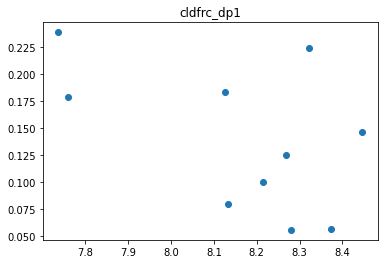

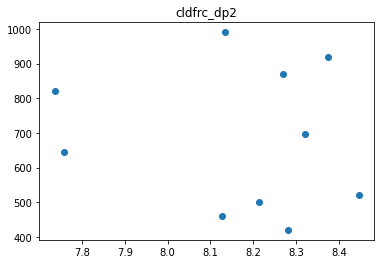

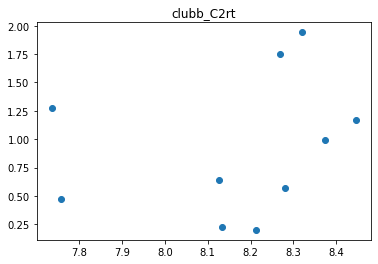

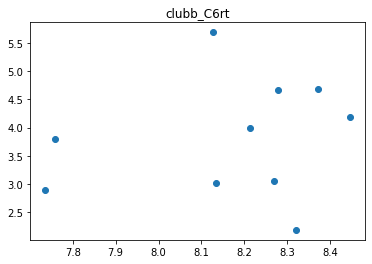

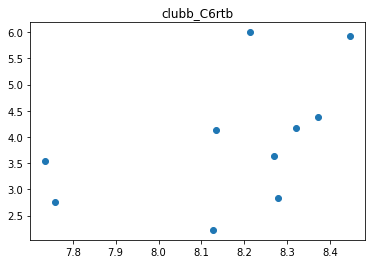

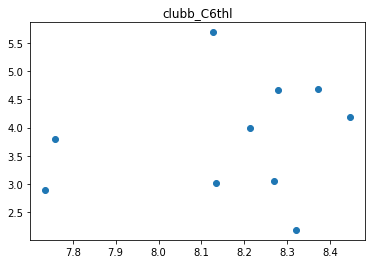

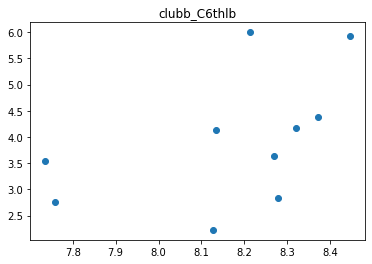

In [68]:
for i in range(10): #len(param_name)
    fig = plt.figure()
    y = f.variables[param_name[i]][0:len(W_plot)]
    plt.scatter(W_plot,y)
    plt.title(param_name[i])